In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Conv1D, TimeDistributed, LSTM
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
np.random.seed(42)

In [4]:
# Use for Google colab after uploading NSRDB_to_model.csv dataset
df = pd.read_csv('./NSRDB_to_model.csv', index_col='datetime')
df.index.name= 'Date'
print(df.shape)
df.head()

(87696, 11)


,Wind_x,Wind_y,Dew Point,Cloud Type,Day Seasonality,Year Seasonality,Pressure,Relative Humidity,Temperature,Solar Zenith Angle,GHI
Date,,,,,,,,,,,
2016-01-01 00:00:00,-0.635439,-0.735724,-5.0,0,-1.407890e-12,-0.002666,990,49.00,5.0,168.95,0
2016-01-01 00:30:00,-0.635439,-0.735724,-5.0,0,1.305262e-01,-0.002308,990,49.00,5.0,166.74,0
2016-01-01 01:00:00,-0.558814,-0.795487,-5.0,0,2.588190e-01,-0.001950,990,48.97,5.0,162.23,0
2016-01-01 01:30:00,-0.558814,-0.795487,-5.0,0,3.826834e-01,-0.001591,990,48.97,5.0,156.74,0
2016-01-01 02:00:00,-0.479173,-0.851865,-5.0,0,5.000000e-01,-0.001233,990,48.98,5.0,150.83,0


In [ ]:
df = pd.read_csv('../data/NSRDB_to_model.csv', index_col='datetime')
df.index.name= 'Date'
print(df.shape)
df.head()

(87696, 11)


,Wind_x,Wind_y,Dew Point,Cloud Type,Day Seasonality,Year Seasonality,Pressure,Relative Humidity,Temperature,Solar Zenith Angle,GHI
Date,,,,,,,,,,,
2016-01-01 00:00:00,-0.635439,-0.735724,-5.0,0,-1.407890e-12,-0.002666,990,49.00,5.0,168.95,0
2016-01-01 00:30:00,-0.635439,-0.735724,-5.0,0,1.305262e-01,-0.002308,990,49.00,5.0,166.74,0
2016-01-01 01:00:00,-0.558814,-0.795487,-5.0,0,2.588190e-01,-0.001950,990,48.97,5.0,162.23,0
2016-01-01 01:30:00,-0.558814,-0.795487,-5.0,0,3.826834e-01,-0.001591,990,48.97,5.0,156.74,0
2016-01-01 02:00:00,-0.479173,-0.851865,-5.0,0,5.000000e-01,-0.001233,990,48.98,5.0,150.83,0


## Data Preprocessing

In our modeling process we will be predicting the following 48 time steps, which correpsonds to 1 day. To make these predictions we have to create sliding windows that will be time sequences that will use a number of time steps to predict 1 day of GHI. 

In [5]:
# Numeric features that will be scaled
num_features = ['Wind_x', 'Wind_y', 'Dew Point', 'Day Seasonality', 'Year Seasonality', 'Pressure', 'Relative Humidity', 'Temperature', 'Solar Zenith Angle']
cloudtypes = keras.utils.to_categorical(df['Cloud Type'])

In [6]:
stacked_data = np.hstack([df[num_features].values])

# Scale
ss = MinMaxScaler()
stacked_sc = ss.fit_transform(stacked_data)
ss_y = MinMaxScaler() #using a separate transformer for GHI so I can easily transform back afterwards
stacked_tot = np.hstack([stacked_sc[:,:], cloudtypes[:,:], ss_y.fit_transform(df[['GHI']].values)])

In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out -1
    
    # check if we are beyond the dataset
        if out_end_ix == len(sequences):
            break
        
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
    
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 240, 48

# covert into input/output
X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)

X.shape (87409, 240, 19)
y.shape (87409, 48)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2)

In [9]:
print(X_train.shape)
print(X_test.shape)

(69927, 240, 19)
(17482, 240, 19)


## WaveNet Model

The Wavenet model was made for generating audio singals and showed to work well for them. Further reading on the model can be found from this [paper](https://arxiv.org/pdf/1609.03499.pdf). This lead to the idea of being used for other forecasting where we can take advantage of the use for longer time sequences. So, we will be applying this model to understand the complex and longevitive relationships of weather and solar radiation predictions. The intial code for the model is taken from this [repo](https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb).

In [10]:
class GatedActivationUnit(keras.layers.Layer):
    """
    Creates a new activation that will elementwise multiple the output of two seperate activations
    """
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'activation': self.activation,
        })
        return config 
    
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.relu(inputs[..., n_filters:])
        return self.activation(linear_output) * gate
        

def wavenet_residual_block(inputs, n_filters, dilation_rate):
    """
    Creates blocks on 1D dilated convolutional layers with gated activations between each convolution.  
    """
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1, kernel_regularizer=l2(0.005))(z)
    return keras.layers.Add()([z, inputs]), z
    

def wavenet_model_setup(n_layers_per_block, n_blocks, n_filters, n_outputs, train_size, feature_dim, name):
    """
    Creates a the wavenet model with the blocks of convolutional layers. Each of the blocks results in a skip 
    layer output that is used in following layers along with the total block output. A dense layer is added
    to set the number of timesteps to predict. 
    
    """
    inputs = keras.layers.Input(shape=[train_size, feature_dim])
    z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
    skip_to_last = []
    for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
        z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
        skip_to_last.append(skip)
    z = keras.activations.relu(keras.layers.Add()(skip_to_last))
    z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu", kernel_regularizer=l2(0.01))(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1, activation='relu', kernel_regularizer=l2(0.005))(z)
    out = layers.Flatten()(z)
    out = Dense(n_outputs)(out)
    return keras.models.Model(inputs=[inputs], outputs=[out], name = name)

In [11]:
# Call function to create out model
model_wave = wavenet_model_setup(n_layers_per_block=8, 
                                 n_blocks=3, 
                                 n_filters=64,
                                 n_outputs=n_steps_out,
                                 train_size=n_steps_in, 
                                 feature_dim=X.shape[-1], 
                                 name='Wave')

In [12]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_wave.compile(loss="mse", optimizer=Nadam(learning_rate=0.001), metrics=['mae'])

history_wave = model_wave.fit(X_train, y_train, 
                              epochs=100, 
                              batch_size=1024,
                              validation_data=(X_test, y_test), 
                              callbacks = [es])


Epoch 1/100
69/69 [==============================] - 120s 1s/step - loss: 5.9030 - mae: 0.0871 - val_loss: 3.3993 - val_mae: 0.0558
Epoch 2/100
69/69 [==============================] - 77s 1s/step - loss: 2.0917 - mae: 0.0488 - val_loss: 1.1127 - val_mae: 0.0500
Epoch 3/100
69/69 [==============================] - 77s 1s/step - loss: 0.6555 - mae: 0.0482 - val_loss: 0.3268 - val_mae: 0.0465
Epoch 4/100
69/69 [==============================] - 77s 1s/step - loss: 0.1863 - mae: 0.0488 - val_loss: 0.0947 - val_mae: 0.0747
Epoch 5/100
69/69 [==============================] - 77s 1s/step - loss: 0.0525 - mae: 0.0500 - val_loss: 0.0275 - val_mae: 0.0459
Epoch 6/100
69/69 [==============================] - 77s 1s/step - loss: 0.0189 - mae: 0.0490 - val_loss: 0.0134 - val_mae: 0.0522
Epoch 7/100
69/69 [==============================] - 77s 1s/step - loss: 0.0110 - mae: 0.0483 - val_loss: 0.0097 - val_mae: 0.0457
Epoch 8/100
69/69 [==============================] - 77s 1s/step - loss: 0.0091 - 

#### Model Evaluation

In [13]:
# Create predictions on the training and test sets for comparison an bias-variance trade-off
preds_train = model_wave.predict(X_train)
preds_test = model_wave.predict(X_test)


#preds_train = model_wave_uni.predict(train_X)
#preds_test = model_wave_uni.predict(test_X)

547/547 [==============================] - 7s 12ms/step


In [14]:
# Revert min-max scaling for interpratibility of scores
y_test_ghi = ss_y.inverse_transform(y_test)
preds_test_ghi = ss_y.inverse_transform(preds_test)
y_train_ghi = ss_y.inverse_transform(y_train)
preds_train_ghi = ss_y.inverse_transform(preds_train)

In [15]:
mse(y_test_ghi[:,-1], preds_test_ghi[:,-1], squared=False)

96.42674968697484

In [16]:
mae(y_test_ghi[:,-1], preds_test_ghi[:,-1])

45.72749195313756

#### Forecasting Results

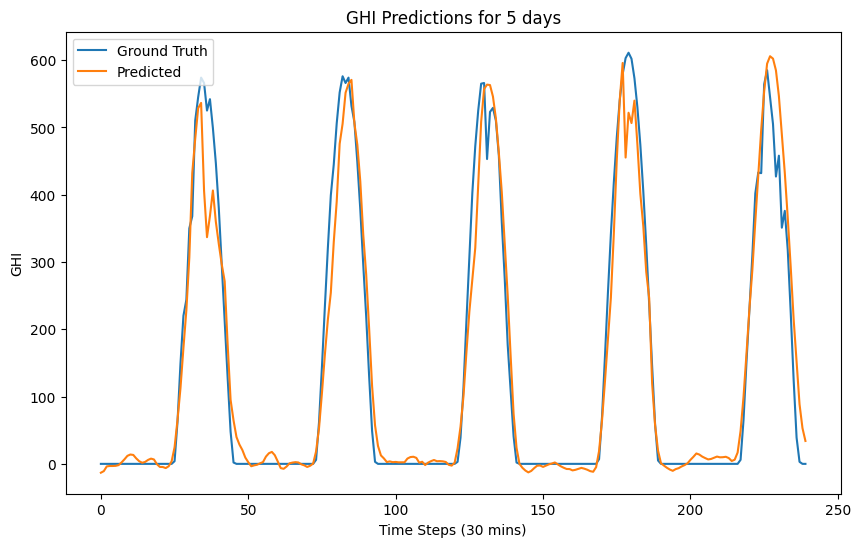

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_ghi[:,-1][:240], label='Ground Truth')
plt.plot(preds_test_ghi[:,-1][:240], label='Predicted')
plt.ylabel('GHI')
plt.xlabel('Time Steps (30 mins)')
plt.title('GHI Predictions for 5 days')
plt.legend();
#plt.savefig('../figures/wavenet_predictions.png') #Uncomment for local notebook use
plt.savefig('wavenet_predictions.png')

#### Filtered Errors

When calculating our error, we have to consider that it will only be valuable to make a solar radiation prediction when the sun is out. So we will filter our predictions to timesteps where the `Solar Zenith Angle` is lower than 90 degrees, which indicates that there is daylight.

In [18]:
def filter_sz(sz, train_y, test_y, n_steps_in):
    """
    Given an input series of solar zenith angle, the train and test y data, and n_steps_in (number of timesteps used to forecast), 
    create boolean arrays in the same shapes as train_y and test_y, which can be used to filter out all datapoints where the sun is down
    (= solar zenith angle below 90 degrees)
    """
    
    #find all indexes where the solar zenith angle is above 90 in the OG dataframe
    sz_mask = np.where(df['Solar Zenith Angle'] < 90, 1, 0)
    train_y_mask = np.zeros(train_y.shape)
    test_y_mask = np.zeros(test_y.shape)
    n_steps_out = train_y.shape[1] #number of timesteps forecasted
    split_idx = train_y.shape[0] #index of split between train and test
    
    #now loop over each batch in train_y and make a mask
    for i in range(train_y.shape[0]):
        start = i + n_steps_in
        stop = i + n_steps_in + n_steps_out
        train_y_mask[i,:] = sz_mask[start:stop]
    for j in range(test_y.shape[0]):
        #print(j)
        start = j + n_steps_in + split_idx -1
        stop = j + n_steps_in + n_steps_out + split_idx -1
        try:
            test_y_mask[j,:] = sz_mask[start:stop]
        except:
            print(j, start, stop)
    return train_y_mask.astype(dtype=bool), test_y_mask.astype(dtype=bool)

In [19]:
train_y_mask, test_y_mask = filter_sz(df['Solar Zenith Angle'], y_train, y_test, n_steps_in)

In [20]:
y_test_ghi_filt = y_test_ghi[test_y_mask]
y_train_ghi_filt = y_train_ghi[train_y_mask]
preds_train_ghi_filt = preds_train_ghi[train_y_mask]
preds_test_ghi_filt = preds_test_ghi[test_y_mask]

In [21]:
print(f'Filtered Training RMSE: {mse(y_train_ghi_filt, preds_train_ghi_filt, squared=False)}')
print(f'Filtered Testing RSME:  {mse(y_test_ghi_filt, preds_test_ghi_filt, squared=False)}')

Filtered Training RMSE: 91.4275843313953
Filtered Testing RSME:  134.99690460589582


In [22]:
print(f'Filtered Trainging MAE: {mae(y_train_ghi_filt, preds_train_ghi_filt)}') 
print(f'Filtered Testing MAE: {mae(y_test_ghi_filt, preds_test_ghi_filt)}')

Filtered Trainging MAE: 59.658202516243
Filtered Testing MAE: 81.54504351874729


After filtering, are errors have increased slightly. When actually taking in consideration times when there is daylight our error is larger and that could be caused from the unpredictability of the outcome, while no solar radiation is easy to predict. 

### Error Overtime

We will also check the prediction scores on filtered data for `Solar Zenith Angle` based on how many time steps in the future it is being predicted

In [23]:
nf = df[(n_steps_in + n_steps_out+1):].reset_index()
l = list(nf[nf['Solar Zenith Angle'] < 90].index);
l_train, l_test = train_test_split(l, test_size=0.2, shuffle=False)
l_train = [l - X_train.shape[0] for l in l_train]
l_test = [l - X_train.shape[0] for l in l_test]

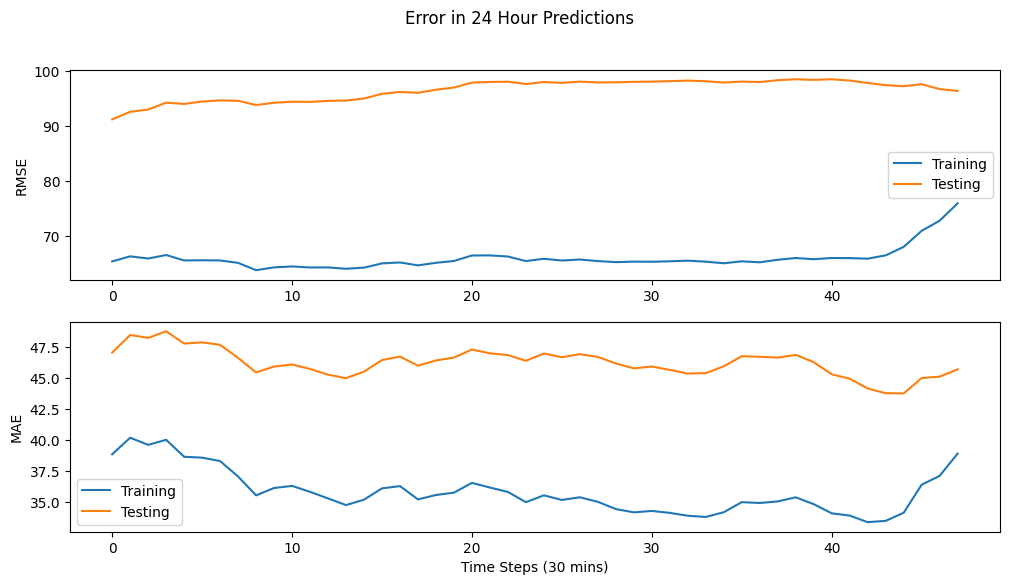

In [24]:
rmse_train = []
mae_train = []
rmse_test = []
mae_test = []

for i in range(n_steps_out):
    y1 = pd.DataFrame(y_train_ghi[:,i].T)
    y1.iloc[l_train, :]
    y2 = pd.DataFrame(preds_train_ghi[:,i].T)
    y2.iloc[l_train, :]
    rmse_train.append(mse(y1, y2, squared=False))
    mae_train.append(mae(y1, y2))
    
    y1 = pd.DataFrame(y_test_ghi[:,i].T)
    y1.iloc[l_test, :]
    y2 = pd.DataFrame(preds_test_ghi[:,i].T)
    y2.iloc[l_test, :]
    rmse_test.append(mse(y1, y2, squared=False))
    mae_test.append(mae(y1, y2))
    

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
fig.suptitle('Error in 24 Hour Predictions')
axes[0].plot(rmse_train, label='Training')
axes[0].plot(rmse_test, label='Testing')
axes[0].set_ylabel('RMSE')
axes[0].legend()

axes[1].plot(mae_train, label='Training')
axes[1].plot(mae_test, label='Testing')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Time Steps (30 mins)')
axes[1].legend();

#fig.savefig('../figures/wavenet_24hr_error.png')  # Uncomment for saving in local notebook
fig.savefig('wavenet_24hr_error.png')

The model has similar prediction errors throughout the majority of the 24 hour forecasting. There appears to be a larger mean absolute error for the first couple of time steps. The biggest problem with the current model is the overfitting of the model. The erros are much smaller in the training set than on the testing set.   